# B1 Render image


In this notebook we use the synthetic package to render a custom galaxy catalog into an image using the galsim wrapper


## Objectives

    1 Learn to turn a galaxy catalog into an image
    
    2 consider which column in the galaxy catalo

    3 Turn fits images into color composites


## Setup

This notebook relies on the:

    * synthetic package & dependencies
    
    * DC2 cutotut data files on disk


## Output

    * fits image in g, r, i band
    
    * color composite image for visualization
    
The output files are placed in the `./data/` folder

## Contact

In case of questions, contact me at t.varga@physik.lmu.de

In [1]:
import fitsio as fio
import numpy as np
import pandas as pd
import pickle as pickle
import copy
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import images # package from erin sheldon

import synthetic.tools as tools
import synthetic.render.frame as frame


# Load galaxy catalog selected from DC2

In [2]:
# File path for input DC2 files
in_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/" 
# output path for mock image, be sure to place it into 
out_path = "data/"

Now we load an arbitrary chunk of DC2, in this case orderedd by a list of healpix pixel cutotuts.

In [3]:
fnames = glob.glob(in_path + "*pixel*h5")
pixels = np.array([int(tmp.split("-")[-1].split(".")[0]) for tmp in fnames])
pixel_id = 0

alltable = pd.read_hdf(fnames[pixel_id], key='data')
ra_cen = np.mean(alltable["ra"])
dec_cen = np.mean(alltable["dec"])

Most galaxies in the catalog are either too faint, or would not fit into the image we are about to render, for this reason we simply cut them out

In [4]:
pad = 0.17 # degree
mag_max = 25 # magniture

#This is just a simple rough cut to exclude most objects
ii = (np.abs(alltable["ra"] - ra_cen) < pad) & (np.abs(alltable["dec"] - dec_cen) < pad) & (alltable['mag_i'] < mag_max)
table = alltable[ii]
ra = (table["ra"] - ra_cen) * 60. 
dec = (table["dec"] - dec_cen) * 60.

## create a catalog to render

To render a galaxy catalog into an image, we have to write a function which translates the columns in the catalog into the photometric features the writer expects. (In this case that is ngmix)

The expected parameters are:

    MAG_G : g band magnitude
    MAG_R : r band magnitude
    MAG_I : i band magnitude
    MAG_Z : z band magnitude
    
    TSIZE : the effective sizeof the galaxy in pixel, ngmix style
    FRACDEV : The percentage fraction De Vaucouleours (1) vs Exponential (0) light profiles (Elliptical vs Spiral)
    G1 : (intrinsic) galaxy shape component 1
    G2 : (intrinsic) galaxy shape component 2
    
    
A simple implementation of thsi mapping would look like the following:

In [5]:
def make_mock(table, sky_center,  pixel_scale=0.2, image_offset=(2499.5, 2499.5)):
    """
    
    """
    mock_catalog = pd.DataFrame()
    mock_catalog["RA"] = table["ra"]
    mock_catalog["DEC"] = table["dec"]
    mock_catalog["X"] = (table["ra"] - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    mock_catalog["Y"] = (table["dec"] - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]

    # This is where the translation begins
    mock_catalog["MAG_G"] = table["mag_g"]
    mock_catalog["FLUX_G"] = tools.toflux(table["mag_g"])
    mock_catalog["MAG_R"] = table["mag_i"]
    mock_catalog["FLUX_R"] = tools.toflux(table["mag_r"])
    mock_catalog["MAG_I"] = table["mag_i"]
    mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
    mock_catalog["MAG_Z"] = table["mag_z"]
    mock_catalog["FLUX_Z"] = tools.toflux(table["mag_z"])

    mock_catalog["TSIZE"] = table["size_true"] # 
    mock_catalog["FRACDEV"] = 0 # This is just a placeholder, put your own function here if you know how that should look like
    mock_catalog["G1"] = table["ellipticity_1_true"]
    mock_catalog["G2"] = table["ellipticity_2_true"]
    
    return mock_catalog

In [6]:
mock_catalog = make_mock(table, sky_center=(ra_cen, dec_cen))

Text(0, 0.5, 'DEC [deg]')

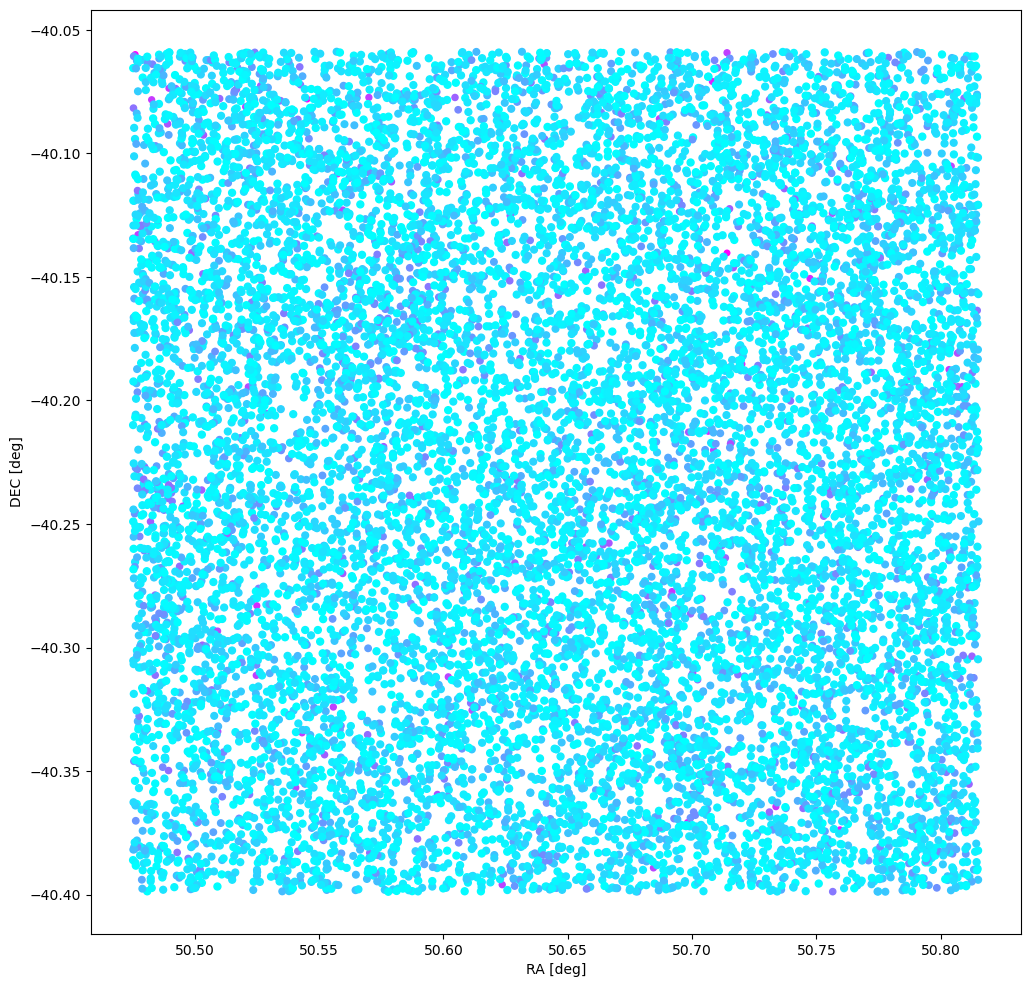

In [7]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)


ax.scatter(mock_catalog["RA"], mock_catalog["DEC"], c=mock_catalog['MAG_I'], s=mock_catalog['MAG_I'],
           cmap=plt.cm.cool_r)
ax.set_xlabel("RA [deg]")
ax.set_ylabel("DEC [deg]")

Pass the galaxy catalog to the frame creator object, which then renders the galaxies and writes a fits image to file

In [8]:
# These are the approcimate noise levels we are going to use for mock images in this notebook
# g, r, i, z bands
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3

# This is the file name root, appended by bands
# we render only g, r, i as those already make a nice color image
file_name_tag = 'test_canvas_dc2_' #

for i, band in enumerate(("g", "r", "i")):
    name = out_path + file_name_tag + band
    print(name)
    fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render() 

data/test_canvas_dc2_g
starting xshear calculations in 100 processes


GalSimBoundsError: Attempt to access subImage not (fully) in image galsim.BoundsI() not in galsim.BoundsI(1,5000,1,5000)

Now read the fits images from file

In [ ]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = out_path + file_name_tag + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)

And we render the three bands together into a nice color composite, with nonlinear arcsinh scaling

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],
                                ims_all[1],
                                ims_all[0],
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin='upper')

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("data/dc2_hp.png", bbox_inches='tight')

In [21]:
ihmaxes = np.argsort(table["halo_mass"])[::-1]

In [22]:
masses = table["halo_mass"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
ras = table["ra"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
decs = table["dec"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
xh, yh = radec2xy(ras, decs, sky_center=(ra_cen, dec_cen))

In [23]:
marker_sizes = (np.log10(masses).values - 12.6) ** 4 * 30

0.9391123056411743


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


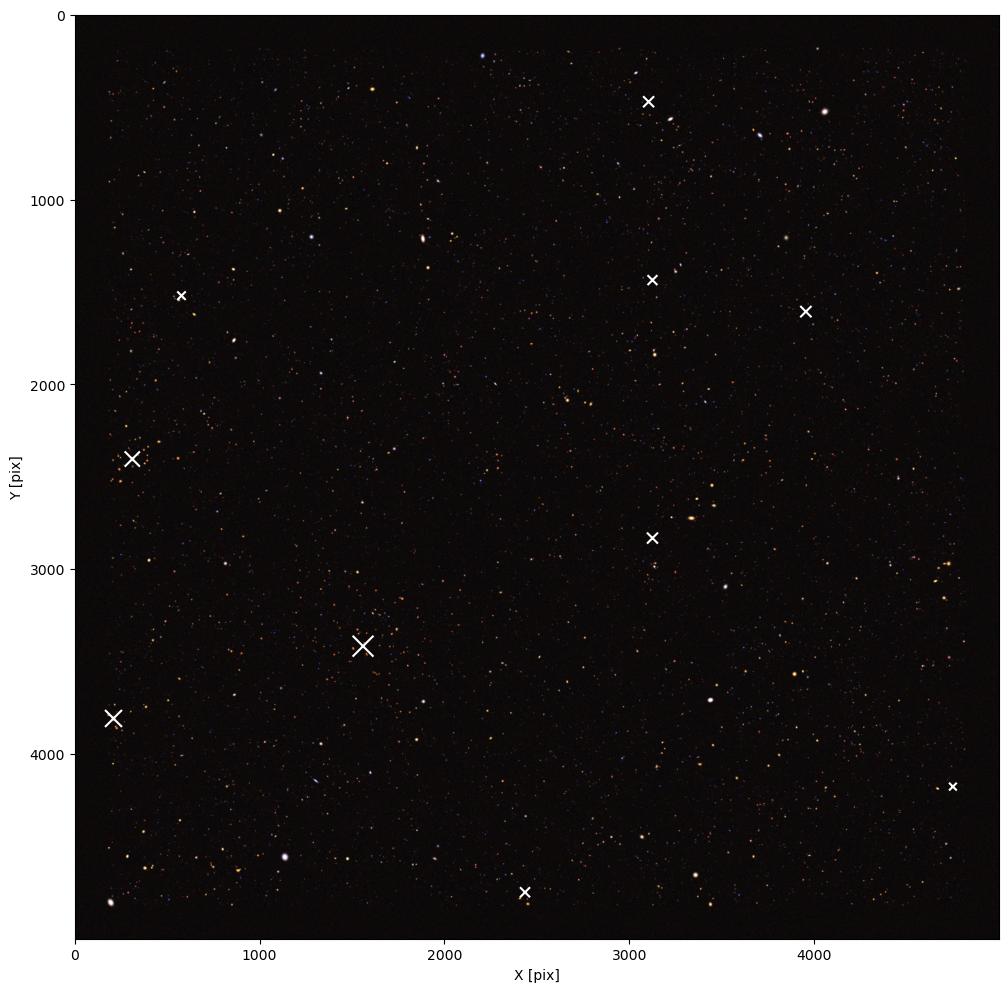

In [24]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
                                ims_all[1],# + ims_icl[1] + noises[1] + pad,
                                ims_all[0],# + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin='upper')
ax.scatter(xh[::-1], yh[::-1], s=marker_sizes[::-1], color="white", marker="x")

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("data/dc2_hp_halos_in_FOV.png", bbox_inches='tight')